# Make pupil large vs small mean FR scatter plot

## TODO:
- check diff min vs max thresholds (using one simple, crit=0.3 seems best)

In [1]:
run -im djd.main -- --dbname=dj_hmov

Connecting write@huxley.neuro.bzm:3306
Connected to database 'dj_hmov' as 'write@10.153.173.165'


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
# warnings.filterwarnings("ignore")

# DJD modules
from djd.hmov_unit import get_pupil_large_vs_small_fr_pmi, plot_fr_scatter

## Get unit keys

In [4]:
df = pd.DataFrame((HmovUnit().fetch(dj.key, as_dict=True)))
df

,m,s,e,u
0,Ntsr1Cre_2019_0007,6,9,1
1,Ntsr1Cre_2019_0007,6,9,2
2,Ntsr1Cre_2019_0007,6,9,3
3,Ntsr1Cre_2019_0007,6,9,4
4,Ntsr1Cre_2019_0007,6,9,5
...,...,...,...,...
154,Ntsr1Cre_2020_0002,6,6,28
155,Ntsr1Cre_2020_0002,6,6,30
156,Ntsr1Cre_2020_0002,6,6,33
157,Ntsr1Cre_2020_0002,6,6,38


## Get mean FRs for pupil large vs small

In [44]:
frs_large = np.full(len(df), np.nan) # same: (0) np.full_like(keys, np.nan), (1) np.full(len(df), np.nan) (2) np.empty(len(keys)) * np.nan
frs_small = np.full(len(df), np.nan)
pmis = np.full(len(df), np.nan)

for i, key in df.head(n=len(df)).iterrows():
    key = key.to_dict()
    try:
        frs_large[i], frs_small[i], pmis[i] = get_pupil_large_vs_small_fr_pmi(key, 
                                                                              eye_crit=0.3, 
                                                                              stimcond='all', 
                                                                              runcond='all')
        print('.', end='')  # print progress
    except:
        print('x', end='')
        continue

# Remove NaNs
frs_small = frs_small[~np.isnan(frs_small)]
frs_large = frs_large[~np.isnan(frs_large)]

.......................................xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx...........................................

## Plot scatter plots

In [41]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })

# Dynamically update plot-specific pars
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
#     'ytick.major.pad': 1, # 3.5
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    })

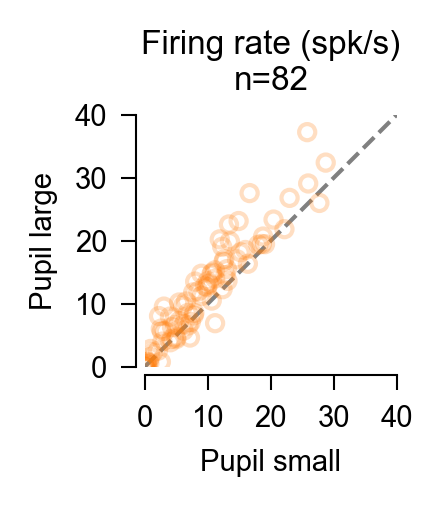

In [9]:
fig, ax = plot_fr_scatter(frs_small, frs_large, labels=['Pupil small', 'Pupil large'], color='tab:orange',
                        logscale=False, axlims=[0, 40], axticks=[0.1,1,10,100], adjust_sp=True, dpi=300,  size=15)
# plt.savefig('pupil_fr_scatter.pdf')

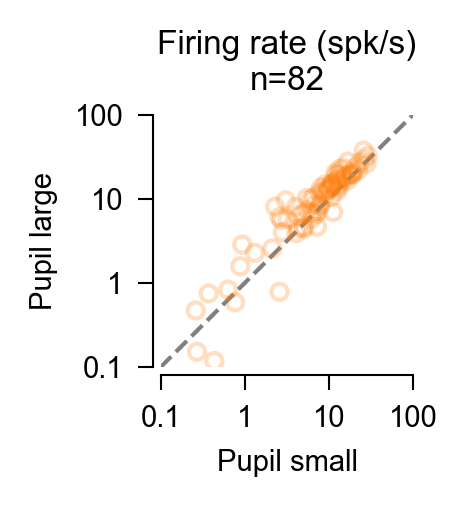

In [146]:
fig, ax = plot_fr_scatter(frs_small, frs_large, labels=['Pupil small', 'Pupil large'], color='tab:orange',
                        logscale=True, axlims=[0.1, 100], axticks=[0.1,1,10,100], adjust_sp=True, dpi=300,  size=15)
# plt.savefig('pupil_fr_scatter.pdf')

## Stats tests

In [144]:
# Perform statistical significance test
# Given that we sample two values from each neuron (ctrl vs opto) and mean FRs in each condition will be dependent on the neuron
# (high FR neurons will likely have high FRs both in ctrl and opto), and given that FRs are likely not normally distributed (but log-normally),
# the Wilcoxon rank signed rank test seems most appropriate

print('Mean FRs pupil small vs large:')

# Wilcoxon signed rank: non-parametric, paired samples
from scipy.stats import wilcoxon
print(wilcoxon(frs_small, frs_large))

# Mann-Whitney U / Mann–Whitney–Wilcoxon (MWW) / Wilcoxon rank-sum test: non-parametric, independent samples
from scipy.stats import mannwhitneyu
print(mannwhitneyu(frs_small, frs_large))#, alternative='less'))

# T-test rel: parametric, paired samples
from scipy.stats import ttest_rel
print(ttest_rel(frs_small, frs_large))

# T-test ind: parametric, independent samples
from scipy.stats import ttest_ind
print(ttest_ind(frs_small, frs_large))

Mean FRs pupil small vs large:
WilcoxonResult(statistic=375.0, pvalue=8.660574203589419e-10)
MannwhitneyuResult(statistic=2838.0, pvalue=0.04256409241292644)
Ttest_relResult(statistic=-7.242640502276403, pvalue=2.2848465156682926e-10)
Ttest_indResult(statistic=-1.8815991369295908, pvalue=0.06168430677919951)


## Test effect when restricting only to sit periods

In [46]:
frs_large = np.full(len(df), np.nan) # same: (0) np.full_like(keys, np.nan), (1) np.full(len(df), np.nan) (2) np.empty(len(keys)) * np.nan
frs_small = np.full(len(df), np.nan)
pmis = np.full(len(df), np.nan)

for i, key in df.head(n=len(df)).iterrows():
    key = key.to_dict()
    try:
        frs_large[i], frs_small[i], pmis[i] = get_pupil_large_vs_small_fr_pmi(key, 
                                                                              eye_crit=0.3, 
                                                                              stimcond='all', 
                                                                              runcond='sit')
        print('.', end='')  # print progress
    except:
        print('x', end='')
        continue

# Remove NaNs
frs_small = frs_small[~np.isnan(frs_small)]
frs_large = frs_large[~np.isnan(frs_large)]

.................................xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx.............................

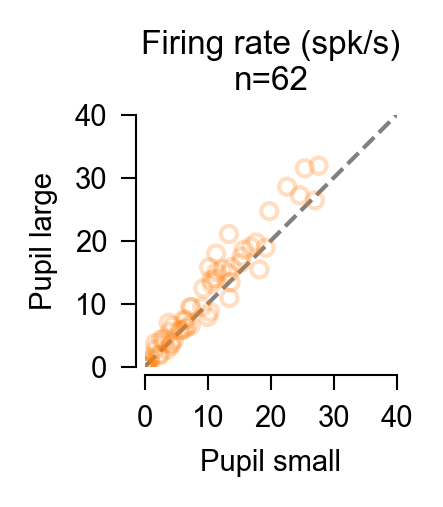

In [47]:
fig, ax = plot_fr_scatter(frs_small, frs_large, labels=['Pupil small', 'Pupil large'], color='tab:orange',
                        logscale=False, axlims=[0, 40], axticks=[0.1,1,10,100], adjust_sp=True, dpi=300,  size=15)
# plt.savefig('pupil_fr_scatter.pdf')

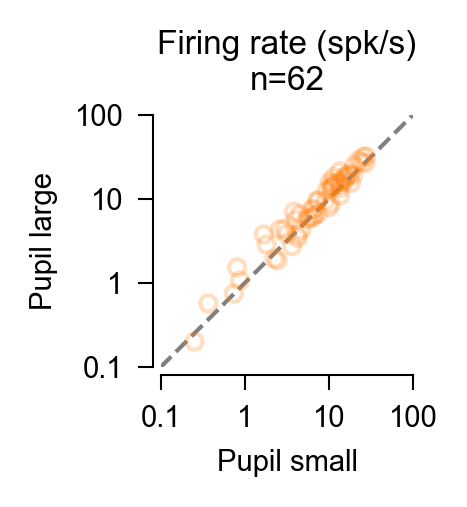

In [49]:
fig, ax = plot_fr_scatter(frs_small, frs_large, labels=['Pupil small', 'Pupil large'], color='tab:orange',
                        logscale=True, axlims=[0.1, 100], axticks=[0.1,1,10,100], adjust_sp=True, dpi=300,  size=15)
# plt.savefig('pupil_fr_scatter.pdf')

In [48]:
# Perform statistical significance test
# Given that we sample two values from each neuron (ctrl vs opto) and mean FRs in each condition will be dependent on the neuron
# (high FR neurons will likely have high FRs both in ctrl and opto), and given that FRs are likely not normally distributed (but log-normally),
# the Wilcoxon rank signed rank test seems most appropriate

print('Mean FRs pupil small vs large:')

# Wilcoxon signed rank: non-parametric, paired samples
from scipy.stats import wilcoxon
print(wilcoxon(frs_small, frs_large))

# Mann-Whitney U / Mann–Whitney–Wilcoxon (MWW) / Wilcoxon rank-sum test: non-parametric, independent samples
from scipy.stats import mannwhitneyu
print(mannwhitneyu(frs_small, frs_large))#, alternative='less'))

# T-test rel: parametric, paired samples
from scipy.stats import ttest_rel
print(ttest_rel(frs_small, frs_large))

# T-test ind: parametric, independent samples
from scipy.stats import ttest_ind
print(ttest_ind(frs_small, frs_large))

Mean FRs pupil small vs large:
WilcoxonResult(statistic=421.0, pvalue=9.83401740244521e-05)
MannwhitneyuResult(statistic=1772.0, pvalue=0.227497576562826)
Ttest_relResult(statistic=-4.757841025069137, pvalue=1.2408591229294167e-05)
Ttest_indResult(statistic=-0.9301424193447786, pvalue=0.3541341913195283)


## Test diff eye crits

...............................................................................................................................................................

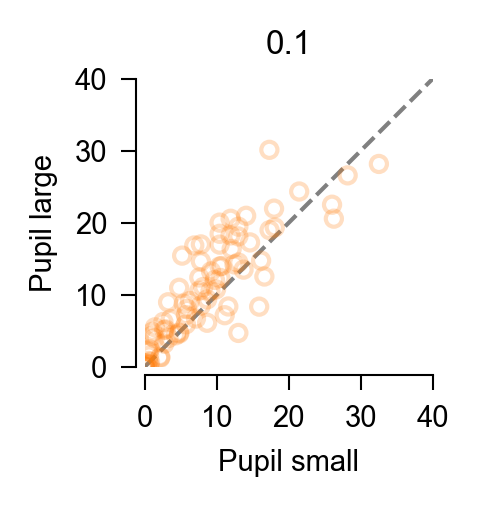

...............................................................................................................................................................

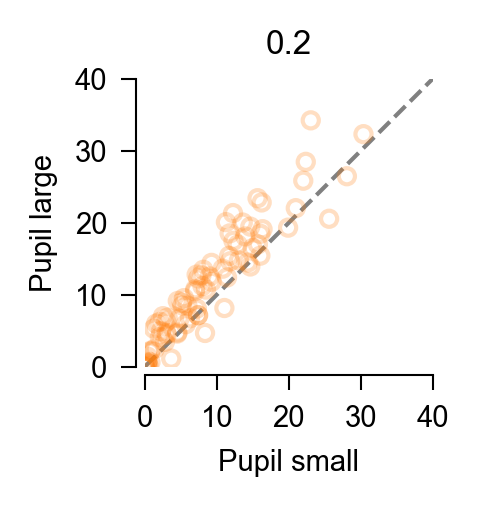

...............................................................................................................................................................

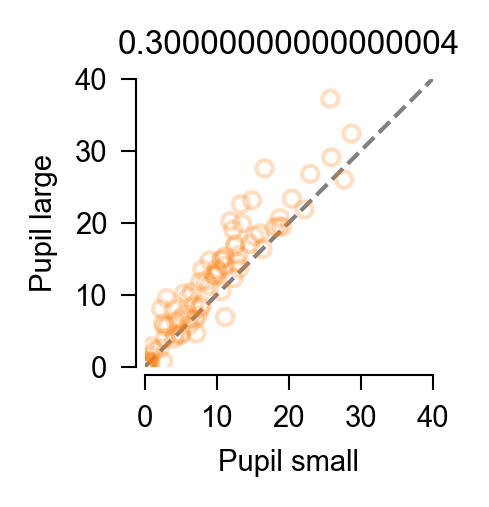

...............................................................................................................................................................

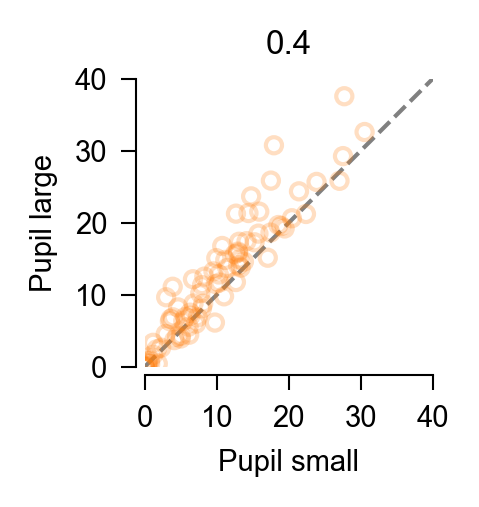

...............................................................................................................................................................

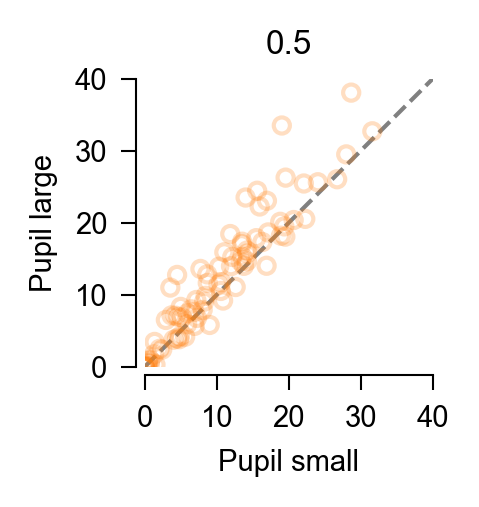

...............................................................................................................................................................

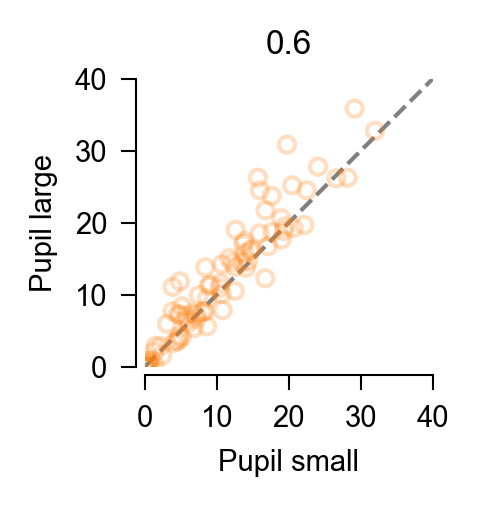

...............................................................................................................................................................

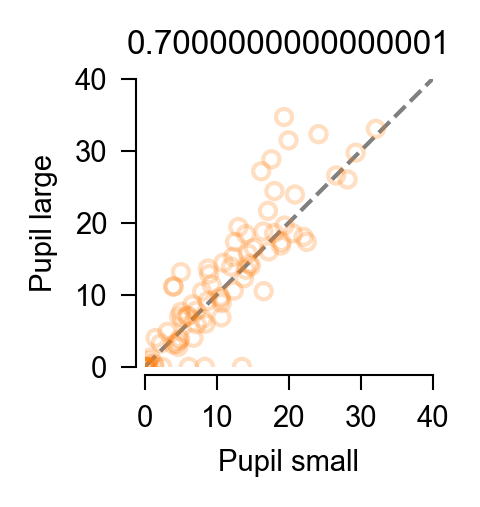

...............................................................................................................................................................

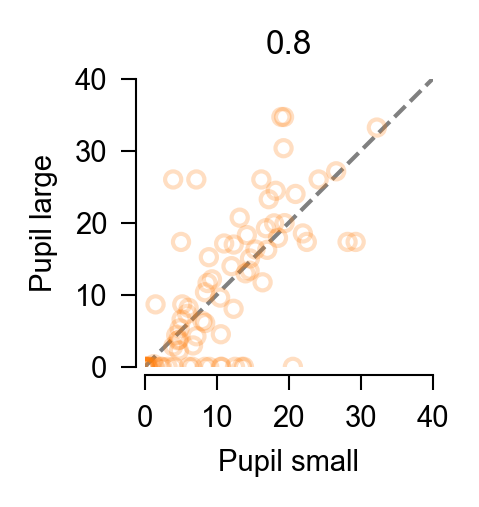

...............................................................................................................................................................

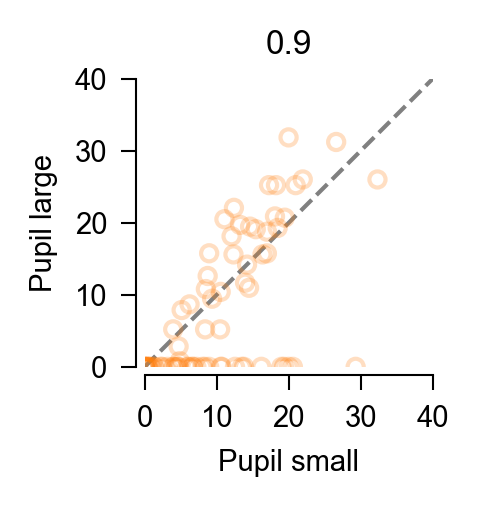

In [130]:
for crit in np.arange(0.1,1,0.1):
    frs_large = np.full(len(df), np.nan)
    frs_small = np.full(len(df), np.nan)
    pmis = np.full(len(df), np.nan)

    for i, key in df.head(n=len(df)).iterrows():
        import pdb
    #     pdb.set_trace()
        key = key.to_dict()
    #     print(key)
        print('.', end='')  # print progress
        try:
            frs_large[i], frs_small[i], pmis[i] = get_pupil_large_vs_small_fr_pmi(key, crit=crit)
        except:
    #         print('Error for:', key)
            continue

    fig, ax = plot_fr_scatter(df, frs_small, frs_large, labels=['Pupil small', 'Pupil large'], color='tab:orange',
                        logscale=False, axlims=[0, 40], axticks=[0.1,1,10,100], adjust_sp=True, dpi=300,  size=15)
    ax.set_title(f'{crit}')
    plt.show()
    # plt.savefig('pupil_fr_scatter.pdf')